# Navigation

---

Project 1 - [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

Importing necessary packages. Neural networks, reinforcement learning agent, replaybuffer and a utility function are loaded form accompanying util.py. The code is very close to the one used to solved the Lunar Lander environment, earlier in this course.

In [1]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import torch
from collections import namedtuple, deque
import numpy as np
import pandas as pd
from util import QNetwork, DuelingQNetwork, Agent, ReplayBuffer, chk_pt_file_name

### 2. Set the correct path to Unity environment

Next, **_before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are on Linux, then you downloaded `Banana.x86` and `Banana.x86_64`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env_path_n_file_name = 'Banana.x86_64'
````

In [2]:
env_path_n_file_name = 'Banana.x86_64'

### 3. Choose between TRAIN or ANALYSIS ONLY
If the `train` variable below is set to True, the training loop begins. If set to False the notebook only evaluates the cells related to analysis of results. With this way of hindering training, one can just restart and rerun entire notebook when in analysis mode if needed, instead of evaluating cell by cell.

train = False

In [3]:
train = False

### 4. Train

If you set `train` to True, the training loop will start below. The loop dumps weights for further analysis every 100th step. Choose `dueling` and `doubleq` to any combination of True/False, to train an agent using either dueling networks and/or double Q estimates.

In [4]:
dueling = False
doubleq = False

if train:
    agent = Agent(state_size=37, action_size=4, seed=0, dueling=dueling, doubleq=doubleq)
    env = UnityEnvironment(file_name=env_path_n_file_name,worker_id=2,seed=1)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        """Deep Q-Learning.

        Params
        ======
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            eps_start (float): starting value of epsilon, for epsilon-greedy action selection
            eps_end (float): minimum value of epsilon
            eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        """
        scores = []                        # list containing scores from each episode
        scores_window = deque(maxlen=100)  # last 100 scores
        eps = eps_start                    # initialize epsilon
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]
            state = env_info.vector_observations[0]
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)                 # act from current state
                env_info = env.step(action)[brain_name]        # find out what happens with chosen action
                next_state = env_info.vector_observations[0]   # get the next state
                reward = env_info.rewards[0]                   # get the reward
                done = env_info.local_done[0]                  # done?
                agent.step(state, action, reward, next_state, done) # add events to experience and maybe learn
                state = next_state                             # save state for next loop
                score += reward
                if done:
                    break 
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                file_name = chk_pt_file_name(i_episode,agent.dueling,agent.doubleq)
                torch.save(agent.qnetwork_local.state_dict(), file_name)
        return scores

    scores = dqn(n_episodes=2000)

    scores_name = 'scores'
    if agent.dueling:
        scores_name += '_dueling'
    if agent.doubleq:
        scores_name += '_doubleq'
    scores_name += '.csv'
    pd.Series(scores).to_csv(scores_name,index=False)

    env.close()

### 5. Analyse Results

Plots of both raw and rolling mean of scores. An accepted solution has a rolling mean score of 13.

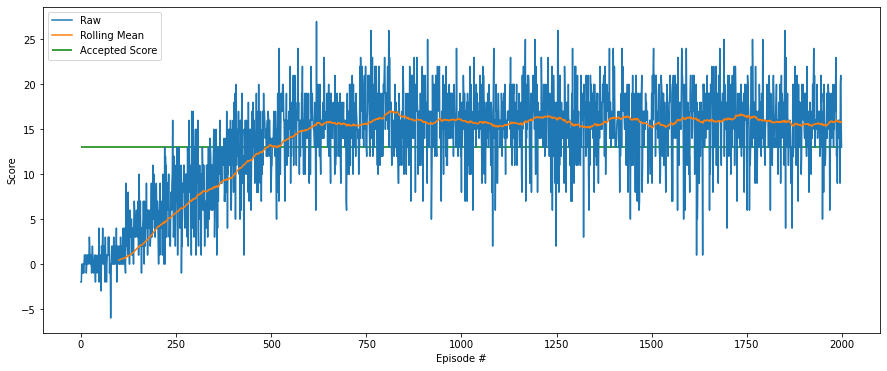

In [5]:
scores = pd.read_csv('scores.csv')
ax = scores.plot(figsize=(15,6))
scores.rolling(window=100).mean().plot(ax=ax)
ax.hlines(13,0,2000,color='g')
plt.legend(['Raw','Rolling Mean','Accepted Score'])
plt.ylabel('Score')
plt.xlabel('Episode #');
#plt.savefig('regular', bbox_inches = 'tight')

Plot rolling mean scores from 2 (or more) methods against each other.

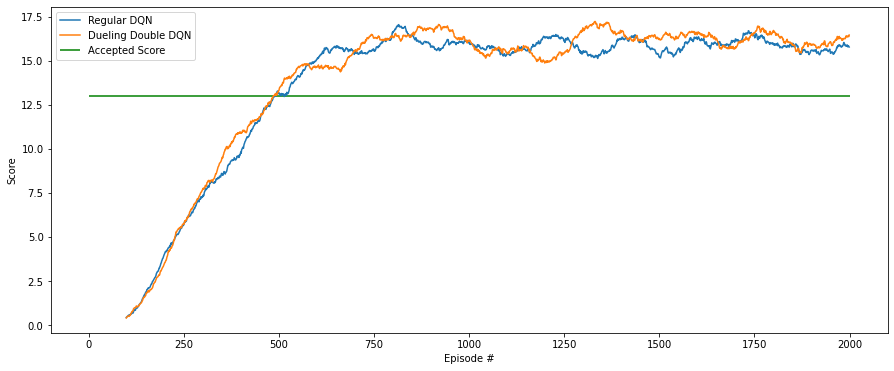

In [6]:
scores = pd.read_csv('scores.csv')
scores_dd = pd.read_csv('scores_dueling_doubleq.csv')
ax = scores.rolling(window=100).mean().plot(figsize=(15,6))
scores_dd.rolling(window=100).mean().plot(ax=ax)
ax.hlines(13,0,2000,color='g')
plt.legend(['Regular DQN','Dueling Double DQN','Accepted Score'])
plt.ylabel('Score')
plt.xlabel('Episode #');
#plt.savefig('regular_and_dd', bbox_inches = 'tight')

### 6. Play game with SMART agent

Load a check point from training above, and see how it performs. Choose whether `dueling` or `double Q` methods should be used, by setting the values when initializing the `Agent`. Set `i_episode` to desired number of training episodes. The training loop above dumps state for every 100th episodes by default.

In [7]:
i_episode = 800
dueling=False
doubleq=False

agent = Agent(state_size=37, action_size=4, seed=0, dueling=dueling, doubleq=doubleq)
file_name = chk_pt_file_name(i_episode,agent.dueling,agent.doubleq)
agent.qnetwork_local.load_state_dict(torch.load(file_name))
env = UnityEnvironment(file_name=env_path_n_file_name,worker_id=2,seed=4)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print('Final score for current game: {0}'.format(score))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Final score for current game: 19.0
